# Code

**Name - Unzela Inamdar**

**Class - IS 1**

**Roll Number - 2173180**

**Enrollment Number - MITU17BTCS0082**

**SUBJECT: Machine Leanring 2**


---

**EXPERIMENT #5** 

---


#**TITLE : ML LAB ASSIGNMENT 5**

---

In [ ]:
!pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
# Folders for Model and Training History
os.makedirs("drive/My Drive/Models2",exist_ok=True)
os.makedirs("drive/My Drive/Logs2",exist_ok=True)

path_to_model="drive/My Drive/Models2"
path_to_logs = "drive/My Drive/Logs2"

# Task List
* CNN for Dataset[Microcontrollers]
* Observe Change in loss accuracy convergence time with different optimizers

# CNN BUILD

## Load The Kaggle Data

### Auth and download kaggle

In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tannergi/microcontroller-detection

 60% 5.00M/8.34M [00:01<00:00, 3.76MB/s]
100% 8.34M/8.34M [00:01<00:00, 6.17MB/s]


In [ ]:
! unzip /content/microcontroller-detection.zip

## Import Libraries

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D ,Flatten , BatchNormalization, Dropout

## Load Labels

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/Microcontroller Detection/train_labels.csv')
test_df = pd.read_csv('/content/Microcontroller Detection/test_labels.csv')

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_20181228_101826.jpg,800,600,Arduino_Nano,317,265,556,342
1,IMG_20181228_101855.jpg,800,600,Heltec_ESP32_Lora,398,243,592,382
2,IMG_20181228_101903.jpg,800,600,ESP8266,290,239,514,387
3,IMG_20181228_101915.jpg,800,600,Raspberry_Pi_3,194,200,669,531
4,IMG_20181228_102013.jpg,800,600,Arduino_Nano,383,336,591,444


## Image augmentation

In [ ]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
train_gen = train_data_gen.flow_from_dataframe(dataframe=train_df,directory='/content/Microcontroller Detection/train',xcol='filename',ycol='class',target_size=(64,64),batch_size=32,class_mode='categorical')

valid_data_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = valid_data_gen.flow_from_dataframe(dataframe=test_df,directory='/content/Microcontroller Detection/test',xcol='filename',ycol='class',target_size=(64,64),batch_size=32,class_mode='categorical',random=False)


Found 170 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.


## Training and creating script

In [ ]:
def model_creation(optimizer , loss   , activation_h,activation_o,input_shape):
  """model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=32,kernel_size=(3,3),activation=activation_h))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters=64,kernel_size=(3,3),activation=activation_h))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128,kernel_size=(3,3),activation=activation_h))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512,activation=activation_h))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(4,activation=activation_o))

  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_h, input_shape=input_shape))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_h))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation=activation_h))
  model.add(tf.keras.layers.Dense(4,activation=activation_o))
  model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
  print(f"Optimizer :{optimizer} Loss: {loss} input shape : {input_shape} ")
  return model
      
def training(model ,train_images,test_images,name,epochs=100 ):
  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f"{path_to_model}/{name}.h5", monitor = 'val_accuracy',verbose=1,save_best_only=True)
  es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
  logs = tf.keras.callbacks.CSVLogger(filename=f"{path_to_logs}/{name}.csv")
  model.fit_generator(train_images,epochs=epochs,validation_data=test_images,callbacks=[checkpointer,es,logs])
  
  return model

  


## Diff parameterts

In [ ]:
optimizers = ['adam','sgd','adagrad','adamax','rmsprop','nadam']
loss = 'categorical_crossentropy'
activation_h = ['relu']
activation_o = 'softmax'
in_shape = (64,64,3)

## Training

In [ ]:
h = []
for o in optimizers:
  for a in activation_h:
    m=model_creation(o,loss,a,activation_o,in_shape)
    model_name = f'cnn_{o}_{a}'
    m = training(m,train_gen,valid_gen,model_name)

# Evaluation Comparizon

In [ ]:
import glob
import tensorflow as tf

## Load All models and logs

In [ ]:
models =  [ tf.keras.models.load_model(x) for x in glob.glob('/content/drive/My Drive/Models2/*.h5')]
logs =  [ pd.read_csv(x) for x in glob.glob('/content/drive/My Drive/Logs2/*.csv')]
names = [x.split('/')[-1].split(".")[0] for x in glob.glob('/content/drive/My Drive/Logs2/*.csv')]

## Graphical Representaion

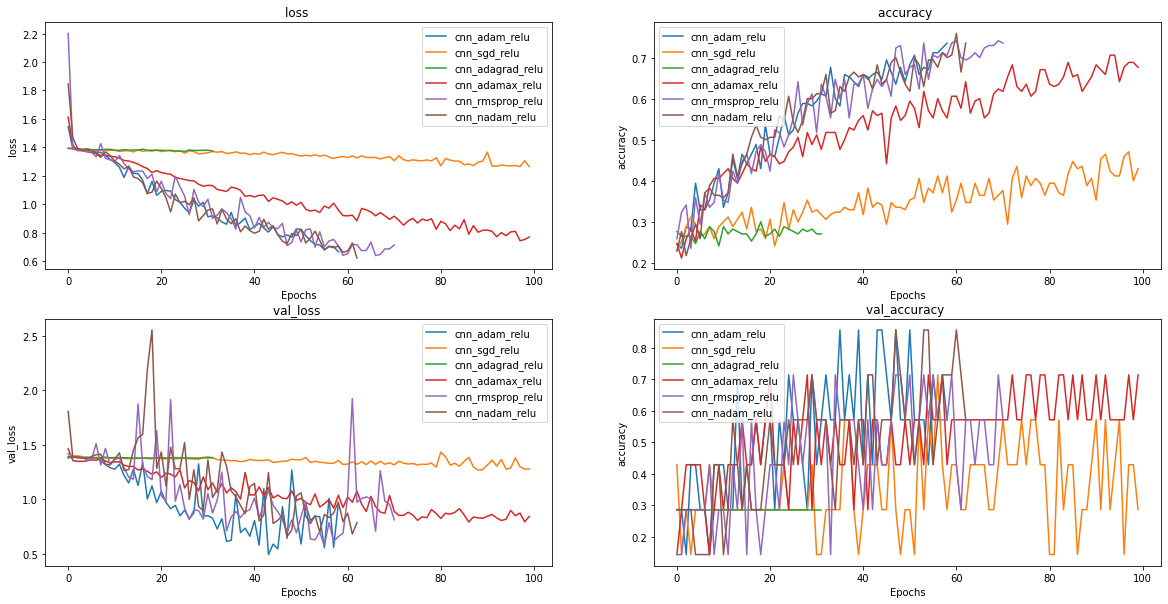

In [ ]:

fig, axs = plt.subplots(2,2,figsize=(20,10))

atr = 'loss'

for j in range(len(logs)):
  axs[0,0].plot(logs[j][atr],label=f'{names[j]}')

axs[0,0].set_title(f'{atr} ')
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel(f"{atr}")
axs[0,0].legend(loc="best")

atr2='accuracy'
for j in range(len(logs)):
  axs[0,1].plot(logs[j][atr2],label=f'{names[j]}')

axs[0,1].set_title(f'{atr2} ')
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel(f"{atr2}")
axs[0,1].legend(loc="best")

atr3 = 'val_loss'
for j in range(len(logs)):
  axs[1,0].plot(logs[j][atr3],label=f'{names[j]}')

axs[1,0].set_title(f'{atr3} ')
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel(f"{atr3}")
axs[1,0].legend(loc="best")

atr4='val_accuracy'
for j in range(len(logs)):
  axs[1,1].plot(logs[j][atr4],label=f'{names[j]}')

axs[1,1].set_title(f'{atr4} ')
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel(f"{atr2}")
axs[1,1].legend(loc="best")


## Accuracy & Loss

In [ ]:
for model , name in zip(models,names):
  loss_t, accuracy_t  = model.evaluate_generator(train_gen,verbose=0)
  loss_v, accuracy_v  = model.evaluate_generator(valid_gen,verbose=0)
  print(f"Training accuracy CNN {name} :{round(accuracy_t*100,4)} %")
  print(f"Training Loss CNN {name} :{loss_t}")
  print(f"Test accuracy CNN  {name}:{round(accuracy_v*100,4)} %")
  print(f"Test Loss CNN {name}:{loss_v}")


Training accuracy CNN cnn_adam_relu :65.8824 %
Training Loss CNN cnn_adam_relu :0.8977435231208801
Test accuracy CNN  cnn_adam_relu:85.7143 %
Test Loss CNN cnn_adam_relu:0.6223214268684387
Training accuracy CNN cnn_sgd_relu :42.3529 %
Training Loss CNN cnn_sgd_relu :1.3241029977798462
Test accuracy CNN  cnn_sgd_relu:71.4286 %
Test Loss CNN cnn_sgd_relu:1.330667495727539
Training accuracy CNN cnn_adagrad_relu :27.6471 %
Training Loss CNN cnn_adagrad_relu :1.3848170042037964
Test accuracy CNN  cnn_adagrad_relu:28.5714 %
Test Loss CNN cnn_adagrad_relu:1.389628291130066
Training accuracy CNN cnn_adamax_relu :47.6471 %
Training Loss CNN cnn_adamax_relu :1.1930814981460571
Test accuracy CNN  cnn_adamax_relu:71.4286 %
Test Loss CNN cnn_adamax_relu:1.1994346380233765
Training accuracy CNN cnn_rmsprop_relu :64.7059 %
Training Loss CNN cnn_rmsprop_relu :0.8921578526496887
Test accuracy CNN  cnn_rmsprop_relu:71.4286 %
Test Loss CNN cnn_rmsprop_relu:0.9185783267021179
Training accuracy CNN cnn_nad

## Compare Classification Report

Cnn cnn_adam_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       1.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0



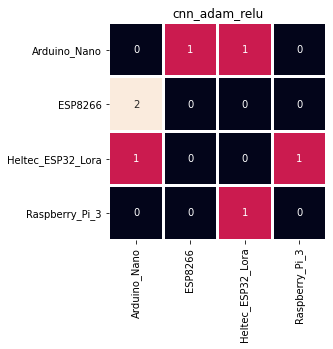

Cnn cnn_sgd_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         1

    accuracy                           0.14         7
   macro avg       0.12      0.12      0.12         7
weighted avg       0.14      0.14      0.14         7



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


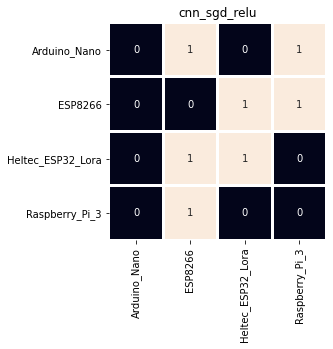

Cnn cnn_adagrad_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.29      1.00      0.44         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1

    accuracy                           0.29         7
   macro avg       0.07      0.25      0.11         7
weighted avg       0.08      0.29      0.13         7



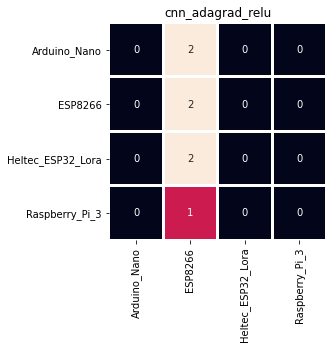

Cnn cnn_adamax_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1

    accuracy                           0.14         7
   macro avg       0.08      0.12      0.10         7
weighted avg       0.10      0.14      0.11         7



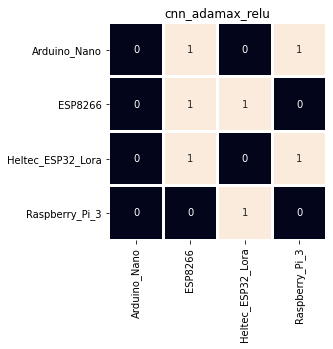

Cnn cnn_rmsprop_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       1.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0



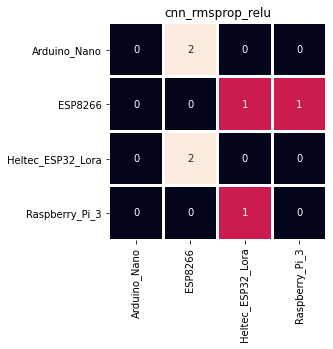

Cnn cnn_nadam_relu Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         1

    accuracy                           0.14         7
   macro avg       0.12      0.12      0.12         7
weighted avg       0.14      0.14      0.14         7



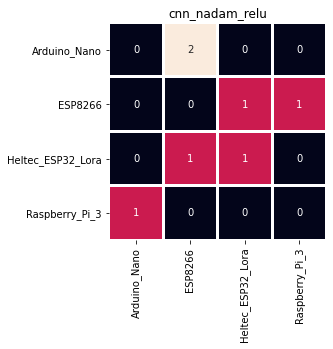

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
for model , name in zip(models,names):
  p=model.predict_generator(valid_gen)
  p = [np.argmax(x) for x in p]
  print(f"Cnn {name} Classification report")
  print(classification_report(valid_gen.classes,p))
  labels =  ['Arduino_Nano','ESP8266','Heltec_ESP32_Lora','Raspberry_Pi_3']
  cm=confusion_matrix(valid_gen.classes,p)
  sns.heatmap(cm,square=True,cbar=False,xticklabels=labels,yticklabels=labels,annot=True,fmt="d",linewidths=2)
  plt.title(f"{name}")
  plt.show()


# Analysis
We observe that the model which uses NADAM reaches the lowest loss and highest accuracy with the dataset.
 
# Conclusion
After this experimentation, we actually learn how different optimizers work and perform while training and how to do different hyperparameter tuning
